# Session Configuration, Library Install ...

In [1]:
from pyspark.sql import SparkSession
from pyspark.sql import *
from pyspark.sql.functions import *
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler

SparkSession.builder.appName("Minute Stock Price Data").getOrCreate()

VBox()

Starting Spark application


ID,YARN Application ID,Kind,State,Spark UI,Driver log,User,Current session?
0,application_1648939494839_0001,pyspark,idle,Link,Link,None,✔


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

SparkSession available as 'spark'.


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [ ]:
# sc.list_packages()
sc.install_pypi_package("pandas==0.25.1")
sc.install_pypi_package("numpy")
sc.install_pypi_package("matplotlib==3.1.1", "https://pypi.org/simple")

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

# Load Minute Pricing Data for 3000 Stock over 2 yrs (~8 GB)

In [4]:
# Load the minute price data for 3000 stocks for the past 2 years
pricing_minute = spark.read.option("header", "true").option("inferSchema", "true").csv("s3://example-data-sharkech/minute_price_3000_stocks_2_yrs/")

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [ ]:
# Debugging / validating the output

pricing_minute.show(1)
pricing_minute.printSchema()

df = pricing_minute.select("time")
df.show()

In [6]:
# Correct data type issues. Convert time feild from a string to a timestamp
pricing_minute = pricing_minute.withColumn("timestamp", to_timestamp("time"))
pricing_minute = pricing_minute.drop("time")

# Add the year, month, dayofmonth columns for rolls up
pricing_minute = pricing_minute.withColumn("year", year("timestamp"))
pricing_minute = pricing_minute.withColumn("month", month("timestamp"))
pricing_minute = pricing_minute.withColumn("dayofmonth", dayofmonth("timestamp"))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

# Load Fundamentals Data for all Stocks

In [7]:
# Load the fundamental data
fundamentals = spark.read.option("header", "true").option("inferSchema", "true").csv("s3://example-data-sharkech/fundamental_data/")

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [ ]:
# Debugging / validating the output

fundamentals.show(1)
fundamentals.printSchema()

# Pricing Data via. Spark + Pandas

In [9]:
# Options : count(), mean(), max(), min(), sum(), avg(), agg()

#
# 1 Stock
#

# Average price per year for 1 stock
pricing_minute_agg = pricing_minute.groupBy("year").mean("AAL").orderBy("year").show()

# Average price per year and month for a single stock
pricing_minute_agg = pricing_minute.groupBy("year", "month").mean("AAL").orderBy("year", "month").show()

# Average price per year, month and day for a single stock
# pricing_minute_agg = pricing_minute.groupBy("year", "month", "dayofmonth").mean("AAL").orderBy("year", "month", "dayofmonth").show(100)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+----+------------------+
|year|          avg(AAL)|
+----+------------------+
|2019|29.199624763714716|
|2020|15.298829816920481|
|2021|19.992139054194876|
+----+------------------+

+----+-----+------------------+
|year|month|          avg(AAL)|
+----+-----+------------------+
|2019|    5| 30.63287532536962|
|2019|    6|31.004839185677167|
|2019|    7| 32.43592605478944|
|2019|    8|26.869529687125635|
|2019|    9| 27.84115163716084|
|2019|   10|27.817315126606037|
|2019|   11|29.475506894267237|
|2019|   12|27.978391344158144|
|2020|    1|27.436449974410067|
|2020|    2|27.174169856145525|
|2020|    3|14.655740827952906|
|2020|    4|11.144755772138758|
|2020|    5|10.009361590992043|
|2020|    6| 15.10013720643113|
|2020|    7|11.911580462233365|
|2020|    8| 12.92531167511054|
|2020|    9| 12.91991842066858|
|2020|   10| 12.43187615978769|
|2020|   11| 12.67757011036826|
|2020|   12| 16.39046824516564|
+----+-----+------------------+
only showing top 20 rows

## Average Stock Price - Chart

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

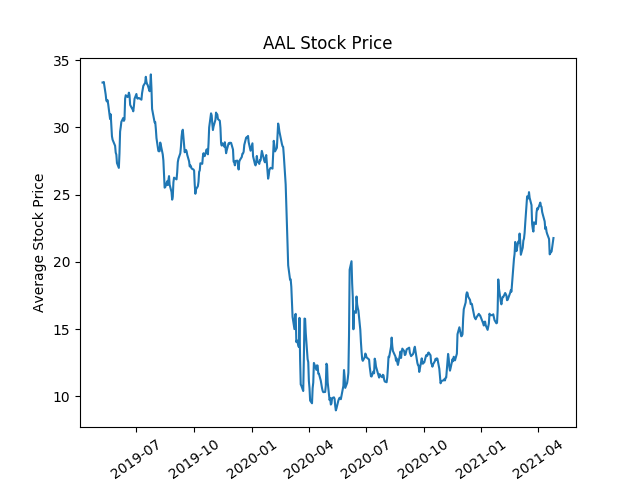

In [10]:
# Visualize results - line chart
pricing_minute_agg = pricing_minute.groupBy("year", "month", "dayofmonth").mean("AAL").orderBy("year", "month", "dayofmonth")
pricing_minute_agg = pricing_minute_agg.withColumn("month/day/year", concat("month", lit("/"), "dayofmonth", lit("/"), "year"))
pricing_minute_agg = pricing_minute_agg.select("month/day/year", col("avg(AAL)").alias("AAL"))

pricing_minute_agg_pd = pricing_minute_agg.toPandas()

pricing_minute_agg_pd['month/day/year'] = pd.to_datetime(pricing_minute_agg_pd['month/day/year'], format='%m/%d/%Y')

x = pricing_minute_agg_pd["month/day/year"]
y = pricing_minute_agg_pd["AAL"]

plt.clf()

plt.ylabel('Average Stock Price')
plt.xlabel('Date')
plt.title('AAL Stock Price')

#plt.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

plt.plot(x, y)
plt.xticks(rotation=35)

%matplot plt

In [11]:
# 
# 3000 Stocks - Sample Queries
# 

# Average price per year for 3000 stocks
# pricing_minute.select( * [mean(c).alias(c) for c in pricing_minute.columns]).orderBy("year").orderBy("year").show()

# Average price per year and month for a 3000 stocks
# pricing_minute.select( * [mean(c).alias(c) for c in pricing_minute.columns]).orderBy("year", "month").orderBy("year", "month").show()

# Average price per year, month and day for 3000 stocks
# pricing_minute.select( * [mean(c).alias(c) for c in pricing_minute.columns]).orderBy("year", "month", "dayofmonth").orderBy("year", "month", "dayofmonth").show(100)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

# Fundamental Data via. Spark + Pandas

In [12]:
# Visualize - Box plot by industry

# Use the fundamental data filter the pricing data set to healthcare sector and a market cap over 1,000,000
health_care_market_cap_1000_plus = fundamentals.filter(fundamentals.sector == "Healthcare").filter(fundamentals.marketcapitalization > 1000000)

stock_symbol_list = list(health_care_market_cap_1000_plus.select('symbol').toPandas()['symbol'])
stock_symbol_list.append('year')
stock_symbol_list.append('month')
stock_symbol_list.append('dayofmonth')

health_care_market_cap_1000_plus_minute_pricing = pricing_minute.select([c for c in pricing_minute.columns if c in stock_symbol_list])

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [13]:
# convert data type to int
fundamentals = fundamentals.withColumn("peratio", fundamentals['peratio'].cast('float'))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

## PE Ration Grouped by Sector - Chart

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

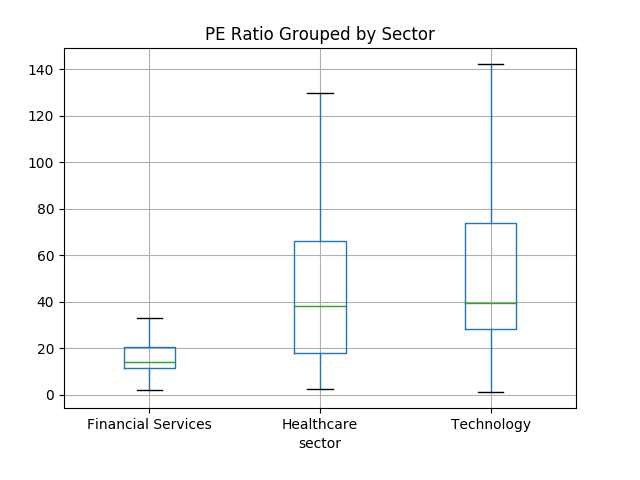

In [14]:
df_fundamentals = fundamentals.toPandas()
# df_fundamentals[df_fundamentals['sector'].isin(['Healthcare', 'Technology', 'Financial Services'])].boxplot(column=['peratio'], by='sector', showfliers=False)

df_sectors_only = df_fundamentals[df_fundamentals['sector'].isin(['Healthcare', 'Technology', 'Financial Services'])]

fig, ax1 = plt.subplots()

df_sectors_only.boxplot(column=['peratio'], by='sector', showfliers=False)

plt.title('PE Ratio Grouped by Sector')
plt.suptitle('')

%matplot plt